# Salt Identification
The salt identification dataset consists of 101x101 pixel images and truth masks.  The mask simply indicates salt or no salt.  We're also provided with a depth value for each image.

In [1]:
import glob 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

# This stops pandas from spitting 
# out warnings at us. 
import warnings
warnings.filterwarnings('ignore')

from skimage.io import imread

%matplotlib inline

/home/david/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/david/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/david/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/david/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/david/.local/lib/python2.7/site-packages/pandas/core/indexes/base.py:7: RuntimeWarning: n

### Constants
I'll define constants that (as suggested by the name) won't be changing values throughout the notebook.  By convention, these are defined in all caps.

In [2]:
BASE_DIRECTORY = '../data/raw/'

# Image sizes for loading. 
IMAGE_WIDTH, IMAGE_HEIGHT = 101, 101
IMAGE_CHANNELS = 1

# U-net will be applied later, and this is the 
# input size that we will use. 
RESIZED_WIDTH, RESIZED_HEIGHT = 128, 128

### Basic Tabular Datasets 
Included in this dataset are two tables.  The first `train_df` contains the identification number of each image in the training dataset and the associated run-length encoded mask.  The second `depth_df` contains all identification numbers for testing and training data, as well as the depth associated with each image.  It's not clear if this depth is an average, or corresponds to the depth at the top/bottom pixel.

In [3]:
train_df = pd.read_csv(BASE_DIRECTORY + 'train.csv')
depth_df = pd.read_csv(BASE_DIRECTORY + 'depths.csv')

In [4]:
train_df.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [5]:
depth_df.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


Snip together the depth and training set.

In [6]:
train_df = train_df.merge(depth_df, on='id')
train_df.head()

,id,rle_mask,z
0,575d24d81d,NaN,843
1,a266a2a9df,5051 5151,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


### Image Datasets 
The meat of the training and testing dataset is stored in `.png` files, the name of which corresponds to the identification number in the dataframes that we loaded above.

In [7]:
#train_image_files = glob.glob(BASE_DIRECTORY + 'train/images/*.png')
#train_mask_files = glob.glob(BASE_DIRECTORY + 'train/masks/*.png')

#print('There are {} training images and {} masks.'.format(len(train_image_files), len(train_mask_files)))

In [8]:
#extract_id = lambda x: x.split('/')[-1].split('.')[0]

#train_image_ids = [extract_id(file) for file in train_image_files]
#train_mask_ids = [extract_id(file) for file in train_mask_files]

In [9]:
train_ids = train_df['id'].values

In [10]:
train_images = [imread('{}train/images/{}.png'.format(BASE_DIRECTORY, id)) / 255.0 for id in train_ids]
train_masks = [imread('{}train/masks/{}.png'.format(BASE_DIRECTORY, id)) / 65535 for id in train_ids]

### Quick Look
Let's have a quick look at the images and masks.

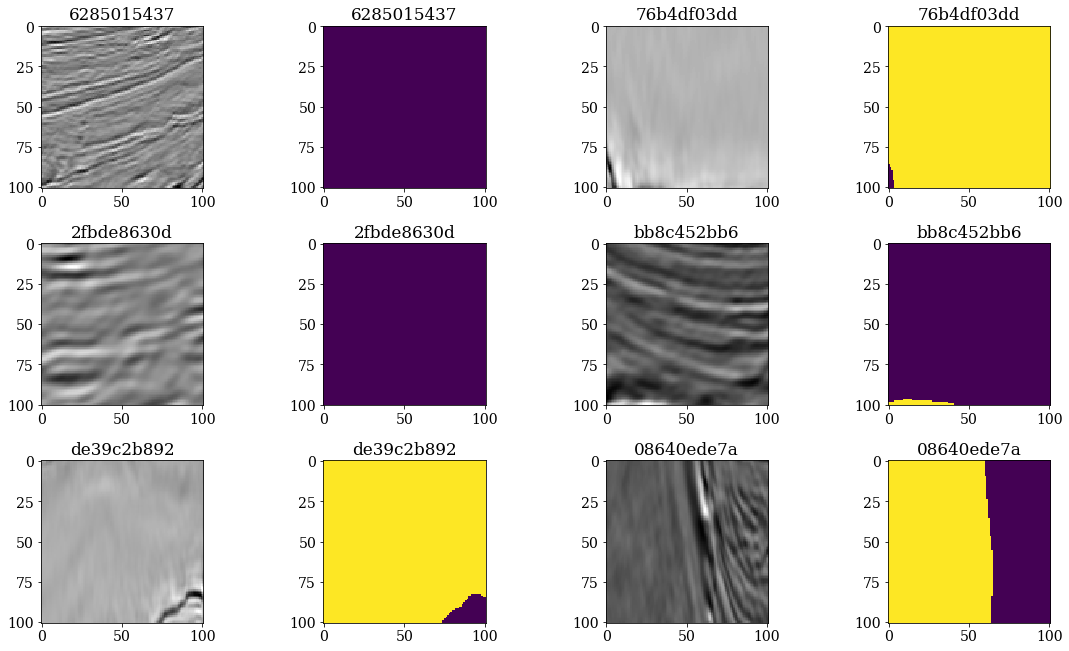

In [11]:
plt.rc('font', family='serif')
plt.rc('font', size=14)

images_to_plot = 6
indices = np.random.randint(0, len(train_images)-1, size=(images_to_plot,))

n_cols = 4
n_rows = np.ceil(2 * images_to_plot / n_cols) + 1

fig = plt.figure( figsize=(4*n_cols, 3*n_rows) )

for i, index in enumerate(indices):
    ax = fig.add_subplot(n_rows, n_cols, 2*i+1)
    ax.imshow(train_images[index])
    ax.set_title(train_ids[index])
    
    ax = fig.add_subplot(n_rows, n_cols, 2*i+2)
    ax.imshow(train_masks[index])
    ax.set_title(train_ids[index])

fig.tight_layout()

### Salt Quantity
Let's quickly calculate the fraction of each mask that is actually salt.  Then, we can try and see if there is a correlation between depth and salt quantity.  If there is no correlation between depth and salt quantity, there may be no gain from including depth in the model.  However, it's possible that there is a correlation between depth and the spatial arrangement of the salt.  If the latter case is true, the depth information should be useful in using different filters to be applied at different depths.

In [16]:
train_df['image'] = train_images
train_df['mask'] = train_masks
train_df['salt_fraction'] = train_df['mask'].apply(np.sum) / 101**2
train_df.head()

,id,rle_mask,z,image,mask,salt_fraction
0,575d24d81d,NaN,843,"[[[0.5254901960784314, 0.5254901960784314, 0.5...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.000000
1,a266a2a9df,5051 5151,794,"[[[0.3411764705882353, 0.3411764705882353, 0.3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468,"[[[0.5686274509803921, 0.5686274509803921, 0.5...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727,"[[[0.5411764705882353, 0.5411764705882353, 0.5...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797,"[[[0.06666666666666667, 0.06666666666666667, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839


In [29]:
train_df.describe()

,z,salt_fraction
count,4000.000000,4000.000000
mean,506.706500,0.247966
std,207.979243,0.318358
min,51.000000,0.000000
25%,351.000000,0.000000
50%,514.000000,0.055485
75%,669.000000,0.469268
max,959.000000,0.999902


In [30]:
train_df.corr()

,z,salt_fraction
z,1.000000,0.103616
salt_fraction,0.103616,1.000000


From the simple statistics here, we can see that the average image is about a quarter salt.  There appears to be a slightly positive correlation between the depth and the fraction of the image which is salt.

Text(0,0.5,'Salt Fraction')

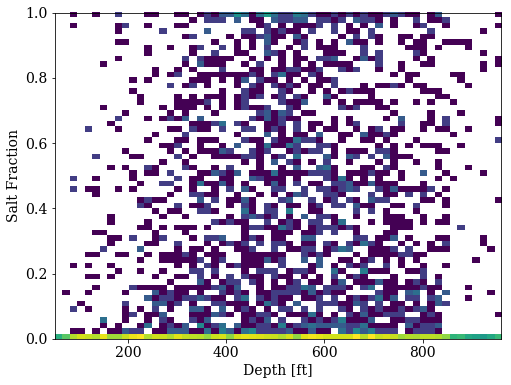

In [28]:
from matplotlib.colors import LogNorm

fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(1,1,1)
ax.hist2d(train_df['z'], train_df['salt_fraction'], bins=60, norm=LogNorm());
ax.set_xlabel('Depth [ft]')
ax.set_ylabel('Salt Fraction')

Text(0.5,0,'Depth [ft]')

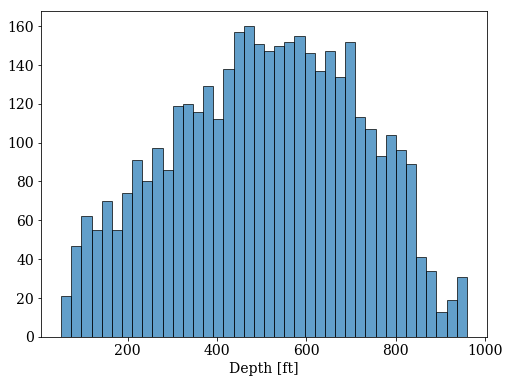

In [39]:
fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(1,1,1)
ax.hist(train_df['z'], bins=40, edgecolor='k', alpha=0.7);
ax.set_xlabel('Depth [ft]')

Text(0.5,0,'Salt Fraction')

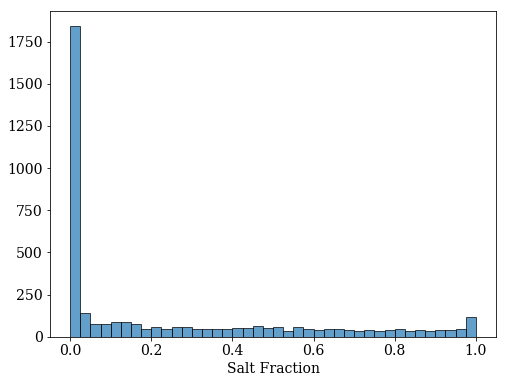

In [40]:
fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(1,1,1)
ax.hist(train_df['salt_fraction'], bins=40, edgecolor='k', alpha=0.7);
ax.set_xlabel('Salt Fraction')

### Not much salt! 
As can be seen in the histogram above, most images have a very small amount of salt.  It would be nice to re-create the depth histogram for training and testing data together.

In [47]:
is_train = lambda x: (x in train_ids)
depth_df['is_train'] = depth_df['id'].apply(is_train).astype(int)

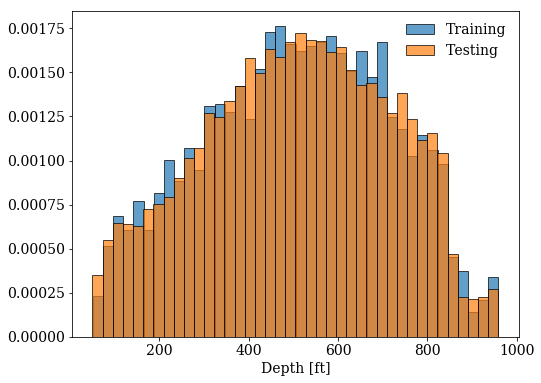

In [59]:
fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(1,1,1)
ax.hist(depth_df.query('is_train == 1')['z'], 
        bins=40, edgecolor='k', alpha=0.7, density=True,
       label='Training');
ax.hist(depth_df.query('is_train == 0')['z'], 
        bins=40, edgecolor='k', alpha=0.7, density=True,
       label='Testing');
ax.set_xlabel('Depth [ft]')
ax.legend(frameon=False)